# Unet
Author Paper: https://arxiv.org/abs/2105.05633

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

class EncodeBlock(nn.Module):
    """Apply 2 successive layers of 3x3 convolutions and ReLU activation."""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encode = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
        )

    def forward(self, x, maxpool_first=False):
        if maxpool_first:
            x = F.max_pool2d(x, kernel_size=2, stride=2)
        return self.encode(x)

class DecodeBlock(nn.Module):
    """Upsample using 2x2 transposed convolution layers, concatenate with skip
    connections, and then apply 2 successive layers of 3x3 convolutions and ReLU."""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        ## Upsample need to halve the feature maps to have the same shape 
        ## with skip connection 
        self.upsample = nn.ConvTranspose2d(
            in_channels,
            in_channels // 2,
            kernel_size=2,
            stride=2,
        )
        self.decode = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
        )

    def forward(self, x, skip):
        x = self.upsample(x)
        # Crop skip tensor (based on
        # https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py)
        height_diff = skip.size()[2] - x.size()[2]
        width_diff = skip.size()[3] - x.size()[3]
        pad = [
            width_diff // 2, width_diff - width_diff // 2, # Pad last dimension
            height_diff // 2, height_diff - height_diff // 2, # Pad second-to-last dimension
        ]
        x = F.pad(x, pad)
        x = torch.cat([x, skip], dim=1)
        return self.decode(x)
class SimpleUNet(nn.Module):
    """Basic U-Net model architecture."""

    def __init__(self, in_channels, n_classes):
        super().__init__()

        # Create encoder (channel dimensions based on original U-Net paper)
        self.encode_1 = EncodeBlock(in_channels, 64)
        self.encode_2 = EncodeBlock(64, 128)
        self.encode_3 = EncodeBlock(128, 256)
        self.encode_4 = EncodeBlock(256, 512)

        self.encode_last = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        # Create decoder
        self.decode_1 = DecodeBlock(1024, 512)
        self.decode_2 = DecodeBlock(512, 256)
        self.decode_3 = DecodeBlock(256, 128)
        self.decode_4 = DecodeBlock(128, 64)

        # Original paper used a 1x1 convolution to map features to n_classes
        self.decode_last = nn.Conv2d(64, n_classes, kernel_size=1) #1x1 Conv2d


    def forward(self, x):
        # Encoding
        x1 = self.encode_1(x)
        x2 = self.encode_2(x1, maxpool_first=True)
        x3 = self.encode_3(x2, maxpool_first=True)
        x4 = self.encode_4(x3, maxpool_first=True)
        x = self.encode_last(x4)
        # Decoding
        x = self.decode_1(x, skip=x4)
        x = self.decode_2(x, skip=x3)
        x = self.decode_3(x, skip=x2)
        x = self.decode_4(x, skip=x1)
        outputs = self.decode_last(x)
        return outputs


In [3]:
# Import utils
from lightning.pytorch.loggers import CSVLogger
from lightning_utils import SegModule, SegDM
import lightning as L

# Shenzen

In [4]:
shenzen_dm = SegDM(
    batch_size=2,
    mask_dir='./datasets/Shenzhen/mask',
    img_dir='./datasets/Shenzhen/img',
)

unet = SimpleUNet(in_channels=3, n_classes=2)

shenzen_logger = CSVLogger("logs", name=f"shenzen_unet", flush_logs_every_n_steps=1)
shenzen_module = SegModule(unet, num_classes=2, result_path='shenzen_test.csv')
shenzen_trainer = L.Trainer(fast_dev_run=False, logger=shenzen_logger, max_epochs=20)
shenzen_trainer.fit(shenzen_module, shenzen_dm)
shenzen_trainer.test(shenzen_module, shenzen_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | SimpleUNet       | 31.0 M | train
1 | loss_fn   | CrossEntropyLoss | 0      | train
2 | f1        | BinaryF1Score    | 0      | train
3 | accuracy  | BinaryAccuracy   | 0      | train
4 | recall    | BinaryRecall     | 0      | train
5 | precision | BinaryPrecision  | 0      | train
6 | mean_iou  | MeanIoU          | 0      | train
-------------------------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.127   Total estimated model params size (MB)


318 examples in the training set...
106 examples in the validation set...
Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/haily/.pyenv/versions/3.10.4/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


/Users/haily/.pyenv/versions/3.10.4/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0:   4%|▍         | 7/159 [00:11<04:01,  0.63it/s, v_num=2]

/Users/haily/.pyenv/versions/3.10.4/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
/Users/haily/.pyenv/versions/3.10.4/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


142 examples in the test set...
Testing DataLoader 0:   0%|          | 0/71 [00:00<?, ?it/s]

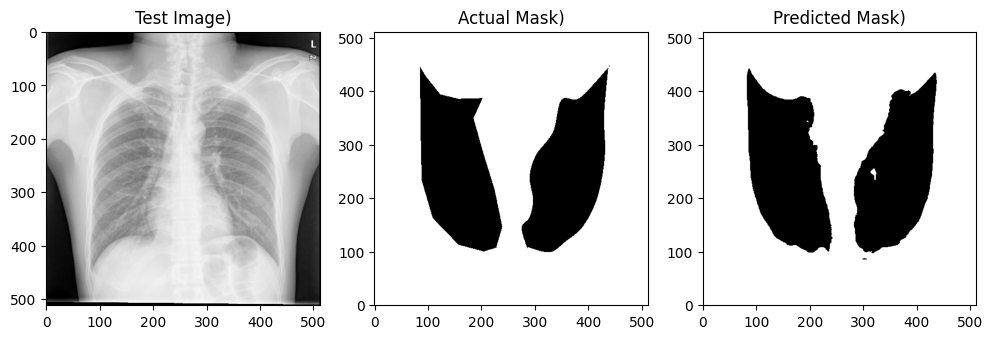

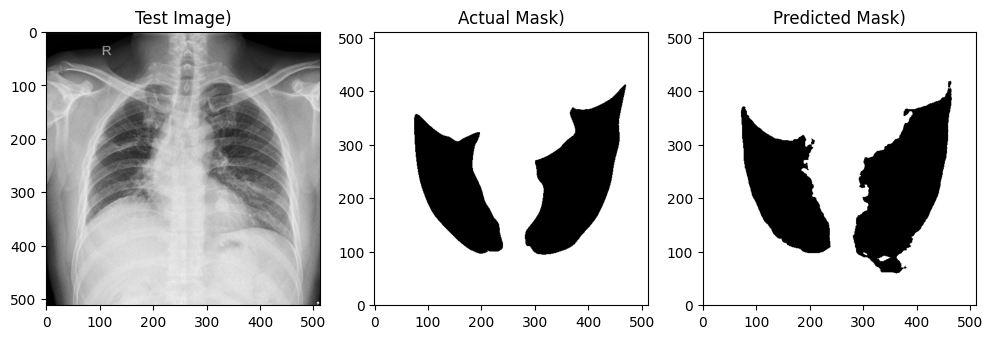

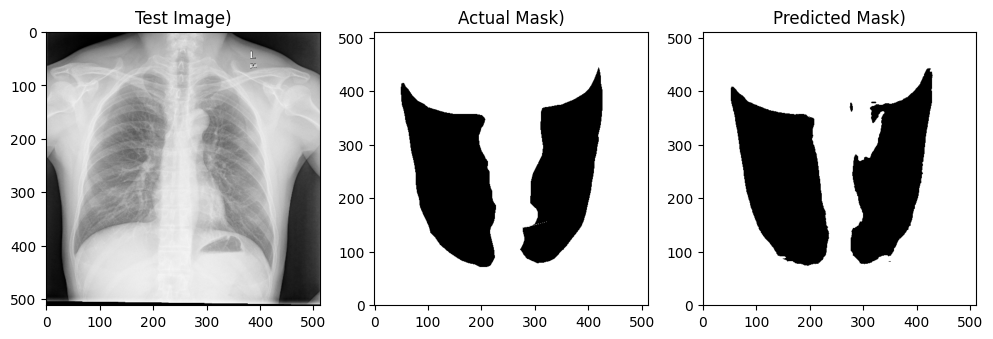

In [44]:
import matplotlib.pyplot as plt
trained = SegModule.load_from_checkpoint('./logs/shenzen_unet/version_0/checkpoints/epoch=19-step=3180.ckpt', model=SimpleUNet(in_channels=3, n_classes=2))
device = torch.device("cuda" if torch.cuda.is_available() else "mps")

start_idx, end_idx = 0, 3 # Select 3 images to plot

for i in range(start_idx, end_idx): # Select 3 images to plot
    test_image, test_mask = shenzen_dm.test[i]
    out = trained.model(test_image.to(device).unsqueeze(0))[0]
  
    prediction = torch.argmax(out, 0)
    fig, ax = plt.subplots(1, 3, figsize=(12, 8))
    ax[0].imshow(test_image.permute(1, 2, 0))
    ax[1].imshow(test_mask, cmap='gray', vmin=0, vmax=1, origin='lower')
    ax[2].imshow(prediction.detach().cpu().numpy(), cmap='gray', vmin=0, vmax=1, origin='lower')

    ax[0].set_title(f'Test Image)')
    ax[1].set_title(f'Actual Mask)')
    ax[2].set_title(f'Predicted Mask)')

    plt.show();

# Darwin

In [13]:
d_dm = SegDM(
    batch_size=2,
    mask_dir='./datasets/Darwin/mask',
    img_dir='./datasets/Darwin/img',
)

d_unet = SimpleUNet(in_channels=3, n_classes=2)

d_module = SegModule(unet, num_classes=2, result_path='darwin_unet_test.csv')

d_trainer = L.Trainer(
    fast_dev_run=False, 
    logger=CSVLogger("logs", name=f"darwin_unet", flush_logs_every_n_steps=1), 
    max_epochs=20)

d_trainer.fit(d_module, d_dm)
d_trainer.test(d_module, d_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | SimpleUNet       | 31.0 M | train
1 | loss_fn   | CrossEntropyLoss | 0      | train
2 | f1        | BinaryF1Score    | 0      | train
3 | accuracy  | BinaryAccuracy   | 0      | train
4 | recall    | BinaryRecall     | 0      | train
5 | precision | BinaryPrecision  | 0      | train
6 | mean_iou  | MeanIoU          | 0      | train
-------------------------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.127   Total estimated model params size (MB)


3434 examples in the training set...
1145 examples in the validation set...
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/haily/.pyenv/versions/3.10.4/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


/Users/haily/.pyenv/versions/3.10.4/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0:  30%|███       | 518/1717 [14:21<33:14,  0.60it/s, v_num=1]

/Users/haily/.pyenv/versions/3.10.4/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
/Users/haily/.pyenv/versions/3.10.4/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


1527 examples in the test set...
Testing DataLoader 0:   3%|▎         | 25/764 [00:15<07:30,  1.64it/s]

# Covid

In [ ]:
c_dm = SegDM(
    batch_size=2,
    mask_dir='./datasets/COVID-19_Radiography_Dataset/COVID/masks',
    img_dir='./datasets/COVID-19_Radiography_Dataset/COVID/images',
)

c_unet = SimpleUNet(in_channels=3, n_classes=2)

c_module = SegModule(unet, num_classes=2, result_path='covid_test.csv')

c_trainer = L.Trainer(
    fast_dev_run=False, 
    logger=CSVLogger("logs", name=f"covid_unet", flush_logs_every_n_steps=1), 
    max_epochs=10)

c_trainer.fit(c_module, c_dm)
c_trainer.test(c_module, c_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | SimpleUNet       | 31.0 M | train
1 | loss_fn   | CrossEntropyLoss | 0      | train
2 | f1        | BinaryF1Score    | 0      | train
3 | accuracy  | BinaryAccuracy   | 0      | train
4 | recall    | BinaryRecall     | 0      | train
5 | precision | BinaryPrecision  | 0      | train
6 | mean_iou  | MeanIoU          | 0      | train
-------------------------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.127   Total estimated model params size (MB)
/Users/haily/.pyenv/versions/3.10.4/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:42

2034 examples in the training set...
678 examples in the validation set...
Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
904 examples in the test set...


/Users/haily/.pyenv/versions/3.10.4/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.6884036064147949     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6884036064147949}]